### Import relevant libraries

In [1]:
# Basics
import pandas as pd
import numpy as np

# Date formats
from datetime import datetime

# EDA stuff
from dython.nominal import identify_nominal_columns, associations

# Model eval 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from statistics import mean
from statistics import stdev

# Custom functions
from functions.data_prep import fish_out_col_lst
from functions.data_prep import data_to_cols
from functions.data_prep import condense_category
from functions.data_prep import change_dtype
from functions.data_prep import create_country_dict
from functions.data_prep import impute_missing_amounts
from functions.eda import pie_chart
from functions.eda import bar_chart_per_year
from functions.eda import bar_chart_avg_per_year
from functions.eda import plot_importance_df
from functions.nlp import clean_name_col
from functions.nlp import tfidf_fit_transform
from functions.nlp import tfidf_transform
from functions.ml import train_regressor
from functions.ml import eval_regressor

# Params for the code to run
from functions.config import seed
from functions.config import date_string
from functions.config import keep_only_finished_campaigns
from functions.config import remove_cat_col
from functions.config import min_df
from functions.config import max_df
from functions.config import test_size

# Put warnings to sleep
import warnings
warnings.filterwarnings('ignore')

### Data Acquisition

In [2]:
# Access data saved locally
df = pd.read_excel('data/input/ks_dataset.xlsx', 
                   index_col = None)

### Data Preparation

In [3]:
# Combine all the data into a single column to avoid messy leaks
df['merged_text'] = df[df.columns].apply(
    lambda x: ','.join(x.dropna().astype(str)).rstrip(','), # Combine all non-null values though remove trailing commas
    axis = 1)

# Fish out column list from excel file
col_lst = fish_out_col_lst(df = df)

# Create df with all the data with consistent comma separation
df_prep = data_to_cols(df,
                       merged_col_name = 'merged_text', 
                       col_lst = col_lst,
                       n_col_with_commas = 2)

# Ensure all columns are the right data type
df_prep = change_dtype(df_prep, 'deadline', 'date')
df_prep = change_dtype(df_prep, 'launched', 'date')

# Remove states that don't report the outcome of the campaign 
# We need full historical period for every campaign
if keep_only_finished_campaigns == True:
    
    df_prep = df_prep[(df_prep['state'] == 'successful') 
                      | (df_prep['state'] == 'failed')]

# Check out output...
df_prep.head(5)

,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd_pledged,name
0,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,The Songs of Adelaide & Abullah
1,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,Where is Hank?
2,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,ToshiCapital Rekordz Needs Help to Complete Album
4,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,Monarch Espresso Bar
5,Food,Food,USD,2014-12-21 18:30:44,1000,2014-12-01 18:30:44,1205,successful,16,US,1205,Support Solar Roasted Coffee & Green Energy! ...


In [4]:
# Still have weird stuff going on around in some columns, with country '"N'
print(df_prep.country.value_counts().head(10))

# Although many of those are undefined, not all are, some are successful
print(df_prep[df_prep['country'] == '"N'].state.value_counts())

# Cannot infer country from currency because well - the EUR, but can infer country from most currencies
country_dict =  create_country_dict(df_prep, 
                                    exclude_eur = True)

US    229822
GB     23877
CA      9912
AU      5195
DE      2131
NL      1873
FR      1559
IT      1394
ES      1090
SE      1066
Name: country, dtype: int64
successful    105
failed        105
Name: state, dtype: int64


In [5]:
# We can infer usd_pledged using pledged amount and deadline date for FX rate - using FX rates of date (not hour) 
# parce qu'on choisit ses combats
df_prep = impute_missing_amounts(df_prep = df_prep,
                                   value_to_replace = '"N', 
                                   country_dict = country_dict, 
                                   currency_col_to_impute = 'usd_pledged', 
                                   country_col_to_impute = 'country')

# Ensure output ok
assert df_prep[df_prep['country'] == '"N'].shape[0] == 0

# Now we can ensure all columns are the right data type
df_prep = change_dtype(df_prep, 'goal', float)
df_prep = change_dtype(df_prep, 'pledged', float)
df_prep = change_dtype(df_prep, 'usd_pledged', float)
df_prep = change_dtype(df_prep, 'backers', int)

In [6]:
# Remove category column - too fragmented to bring useful information to the model
# As well as contradictory sometimes
print(df_prep['category'].value_counts().head(10))

if remove_cat_col == True:
    df_prep.drop(['category'], axis = 1, inplace = True)

Product Design    14540
Documentary       13371
Music             10891
Shorts            10786
Food               9545
Tabletop Games     8830
Video Games        7871
Film & Video       7836
Fiction            7277
Fashion            6997
Name: category, dtype: int64


In [7]:
# Combine extraneous occurrences into the same buckets for categorical variables
cat_cols = ['main_category', 'currency', 'country']
for cat_col in cat_cols:
    df_prep[cat_col] = condense_category(cat_col, 
                                         df_prep, 
                                         min_freq = 2.5)

In [8]:
# Throw in a few new features as well
# Add a column with the number of days set for the campaign
df_prep['duration'] = (df_prep['deadline'] - df_prep['launched']).dt.days

# Add a column to have avg. contribution per backer
df_prep['avg_pledge'] = df_prep['usd_pledged'] /  df_prep['backers']

# And parse both date columns with month and year 
# Maybe we'll find some seasonality trend
df_prep['deadline_year'] = pd.DatetimeIndex(df_prep['deadline']).year
df_prep['launched_year'] = pd.DatetimeIndex(df_prep['launched']).year
df_prep['deadline_month'] = pd.DatetimeIndex(df_prep['deadline']).month
df_prep['launched_month'] = pd.DatetimeIndex(df_prep['launched']).month

In [9]:
df_prep.to_csv(str('data/cache/df_prep_' + date_string + '.csv'))

#### 1. Comme c’est souvent le cas dans les projets, le jeu de données peut nécessiter quelques manipulations pour être utilisable par une approche ML.

Si tu rencontres des problèmes de qualité des données, comment les résoudrais-tu? 

Les difficultés et leurs solutions respectives incluent: 
- Virgules dans le jeu de données 
    - Isoler la colonne des titres de campagnes avec rsplit
    - Conserver toutes les virgules dans la colonne 'name' pour s'assurer que les données n'ont pas été décalées vers la droite
    
    
- 'usd_pledge' et 'country' manquants à quelques endroits
    - Déduire 'usd_pledge' en fonction de la monnaie d'origine et du taux de change de la date de fin de campagne
    - Déduire le pays en fonction de la monnaie, possible pour tous sauf l'euro
    
    
- Données très fragmentées dans les colonnes présentant des catégories
    - Combiner les catégories à basse fréquence sous 'Other'
    - Exclure la colonne 'category'
    
    
- Points de discussion avec le client:
    - Quelques points de données (approx. 5-10) sont désignés comme 'successful' et ont pledged < goal, et quelques sont 'failed' et ont goal >= pledged. Pourquoi?
    - Plusieurs campagnes 'undefined' auraient dû avoir du succès (pledged > goal). Pourquoi ne sont-elles pas ainsi? 
    - La colonne d'index dans le jeu de données contenait-elle de l'information relative aux campagnes ou aux usagers? 
    - La différence entre les campagnes 'canceled' et 'suspended'
    - Pronostiquer la probabilité d'annulation d'une campagne - environ 10% des campagnes dans le jeu de données

### EDA

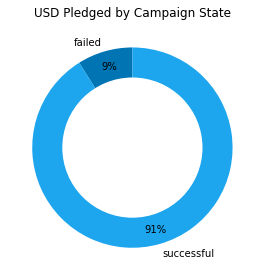

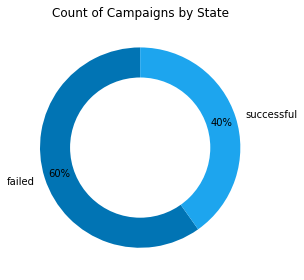

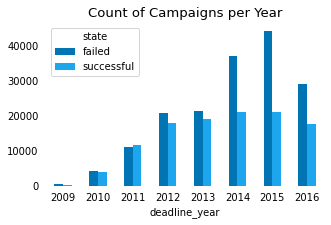

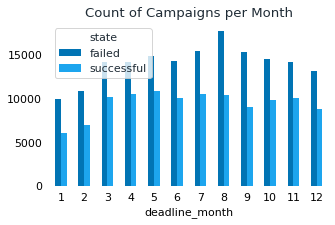

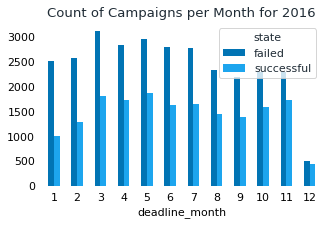

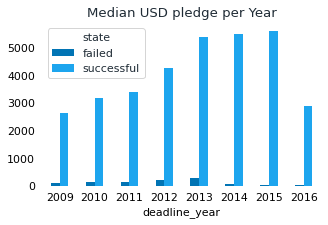

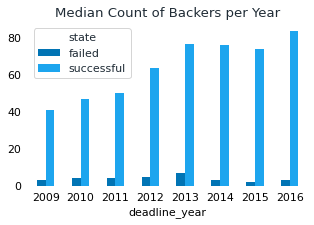

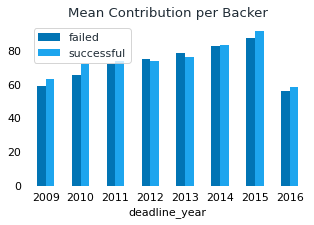

In [10]:
# Generate all the charts relevant to the dataset 
pie_chart(df_prep, 
          'state', 
          count = False, 
          title = 'USD Pledged by Campaign State').savefig(
    str('viz/pie_usdstate_' + date_string + '.jpg'))

pie_chart(df_prep, 
          'state', 
          title = 'Count of Campaigns by State').savefig(
    str('viz/pie_countstate_' + date_string + '.jpg'))

# Segmented Bar charts for state vs. failed by year, and other attributes
bar_chart_per_year(df = df_prep, 
                   values = 'backers',
                   columns = 'state',
                   aggfunc = 'count',
                   title = 'Count of Campaigns per Year').figure.savefig(
    str('viz/bar_campaignscount_' + date_string + '.jpg'))

# Check if success has to do with seasonality
bar_chart_per_year(df = df_prep, 
                   values = 'backers',
                   columns = 'state',
                   aggfunc = 'count',
                   title = 'Count of Campaigns per Month', 
                   index = 'deadline_month').figure.savefig(
    str('viz/bar_seasonal_' + date_string + '.jpg'))

# Check if drop in 2016 is due to year not being fully recorded
bar_chart_per_year(df =  df_prep[df_prep['deadline_year']==2016], 
                   values = 'backers',
                   columns = 'state',
                   aggfunc = 'count',
                   title = 'Count of Campaigns per Month for 2016', 
                   index = 'deadline_month').figure.savefig(
    str('viz/bar_seasonal2016_' + date_string + '.jpg'))

# Check avg. pledge per year
bar_chart_per_year(df =  df_prep, 
                   values = 'usd_pledged',
                   columns = 'state',
                   aggfunc = 'median',
                   title = 'Median USD pledge per Year', 
                   ).figure.savefig(
    str('viz/yearlyUSDpledge_' + date_string + '.jpg'))

# Check median count of backers
bar_chart_per_year(df =  df_prep, 
                   values = 'backers',
                   columns = 'state',
                   aggfunc = 'median',
                   title = 'Median Count of Backers per Year', 
                   ).figure.savefig(
    str('viz/medianbackers_' + date_string + '.jpg'))

# Check that on average, contributions per backer are roughly equal
bar_chart_avg_per_year(df =  df_prep,
                       values_num = 'usd_pledged',
                       values_denom = 'backers',
                       columns = 'state',
                       title = 'Mean Contribution per Backer', 
                       ).figure.savefig(
    str('viz/contribution_per_backer_' + date_string + '.jpg'))

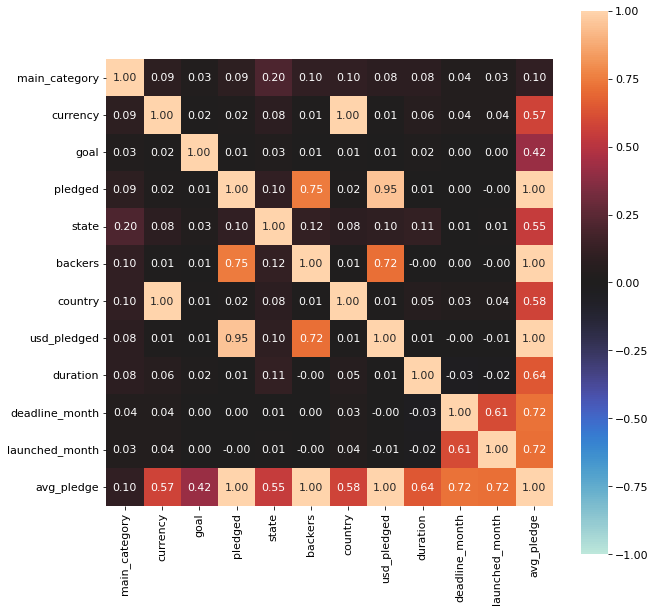

In [11]:
# Check pearson's correlation matrix for num-num variables, 
df_corr = df_prep[['main_category', 'currency', 'goal', 
                   'pledged', 'state', 'backers', 'country',
                   'usd_pledged', 'duration', 'deadline_month', 
                   'launched_month', 'avg_pledge']]

complete_correlation = associations(df_corr, 
                                    figsize = (10, 10),  
                                    nan_replace_value = 'Other', 
                                    filename = str('viz/corrmatrix_' + date_string + '.jpg')
                                   )

#### 2. Identifie des « insights » qui, selon toi, peuvent contribuer à comprendre le succès des campagnes.
- Quels aspects dois-tu prendre en compte pour que tes « insights » et leur interprétation soient statistiquement significatifs?
    - S'assurer de conjuguer à la fois l'observation d'une variable avec l'évolution à travers le temps
    - Observer la corrélation potentielles entre toutes les données numériques
    - Autre étapes potentielles: régression lasso et test chi-square entre variables catégoriques spécifiques
    - Biais: Par exemple la variable 'avg_pledge' est np.nan lorsqu'une campagne a 0 'backers' et 0 en 'usd_pledge'
    

- Est-ce que les « insights » trouvés peuvent être transformés en caractéristiques qui faciliteront l'apprentissage du modèle ML ?

On note que les campagnes à succès attirent beaucoup plus de collaborateurs, mais que leur dons médians sont comparables à ceux des campagnes qui ont échoué. Le problème peut donc être:

- Les usagers qui lancent les campagnes qui échouent sont trop ambitieux, ou
- Les usagers qui lancent les campagnes qui échouent ne récoltent pas assez de fonds. 

Il serait donc plus judicieux de livrer un modèle de régression pour suggérer à l'usager un montant que sa campagne est susceptible de récolter, d'autant plus que plusieurs variables ci-dessus ne sont disponibles qu'après la fin de la campagne ('backers', 'pledge', 'state', etc.) Si le modèle arrive à prédire 'usd_pledged' avec succès et que l'usager ajuste son objectif en fonction de cette prédiction, la proportion de campagnes qui échouent devrait chuter significativement.


##### Point de discussion: Pour pronostiquer le montant amassé par chaque campagne plutôt que la probabilité d'échec?




### Feature Engineering: Extract Data from Name Column

In [12]:
# To speed up processing, only look at a fraction a fraction of the old data frame
### Important - do SRS before you send to tf-idf ###
df_sample = df_prep.sample(frac = 0.1, random_state = seed)

In [13]:
# Convert the unstructured name column into structured data
name_vector = clean_name_col(df = df_sample , name_col = 'name')

# Only include the columns with which we'd have reasonable access
train_cols = ['main_category', 
               'currency', 
               'launched_month', 
               'duration',
               'country', ]

df_pred_enc = df_sample[train_cols]
# Ensure month is categorical as well
df_pred_enc['launched_month'] = df_pred_enc['launched_month'].astype(str)
df_pred_enc = pd.get_dummies(df_pred_enc[train_cols])
df_pred_enc['name'] = name_vector

# Train test split - before tf-idf
X_train, X_test, y_train, y_test = train_test_split(df_pred_enc, 
                                                    df_sample['usd_pledged'], 
                                                    test_size = test_size, 
                                                    random_state = seed)

# And build the tf-idf matrix, once the data has been split
vectorizer, xtrain_result = tfidf_fit_transform(X_train['name'], 
                                                 min_df = min_df,
                                                 max_df = max_df, 
                                                 df_prep = X_train)

xtest_result = tfidf_transform(X_test['name'],
                                vectorizer = vectorizer, 
                                df_prep = X_test)

# Concatenate tf idf matrix with data we can use for the prediction
X_train = pd.concat([X_train, xtrain_result], axis = 1)
X_train.drop(['name'], axis = 1, inplace = True)
X_test = pd.concat([X_test, xtest_result], axis = 1)
X_test.drop(['name'], axis = 1, inplace = True)

### Train and Test Regressor

In [14]:
# Fit and Predict using the regressor model
regressor  = train_regressor(X_train = X_train, 
                             y_train = y_train)

y_train, ypred_train, y_test, ypred = eval_regressor(X_train = X_train, 
                                                       y_train = y_train, 
                                                       X_test = X_test, 
                                                       y_test = y_test, 
                                                       regressor = regressor)

Train Set Statistics: 
MSE:  417475119.9757065
RMSE:  20432.20790750981
MAPE:  1.1947344955842499e+18
MAE:  3004.0645861049056
Test Set Statistics: 
MSE:  4316369558.004947
RMSE:  65699.08338785973
MAPE:  3.8517087561358116e+18
MAE:  12325.028669742695


In [15]:
# Model Cross-Validation
kfold = KFold(n_splits = 5, shuffle = True, random_state = seed)

# Evaluate the model and collect the scores
n_scores = cross_val_score(regressor, 
                           X_train, y_train, 
                           scoring = 'neg_root_mean_squared_error', 
                           cv = kfold, 
                           n_jobs = -1)

# report performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), stdev(n_scores)))

RMSE: -62835.343 (12566.213)


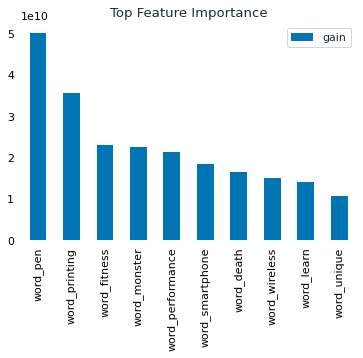

In [16]:
# Interpretation
# Seek out feature importance score
f_importance = regressor.get_booster().get_score(importance_type = 'gain')
importance_df = pd.DataFrame.from_dict(data = f_importance, 
                                       orient = 'index')

importance_df['feature'] = importance_df.index
importance_df.columns = ['gain', 'feature']
importance_df.sort_values('gain', inplace = True, ascending=False)
plot_importance_df(importance_df, title = 'Top Feature Importance').figure.savefig(
    str('viz/feature_importance_' + date_string + '.jpg'))

#### 3. Au niveau de la solution ML:
- Comment interprètes-tu les résultats produits par ta solution ML ?
    - Overfit pour l'algorithme XGBoost:
        - Bayesian/Grid/Random Search pour optimiser les hyperparamètres; pour xgboost early_stopping_rounds, n_estimators, max_depth, colsample_bytree, subsample, gamma, min_child_weight
        - Opter pour d'autres algorithmes de régression moins prônes à l'overfit
        - Modifier la partie tf-idf de la donnée en standardisant le texte (stemming/lemmatising), ou en normalisant la matrice (L1, L2)
        - Pronostiquer en se basant sur le jeu de données complet plutôt qu'un échantillon, et utiliser plus de mots parmi le colonnes de la matrice tf-idf
        - Augmenter le minimum requis pour condenser la colonne 'category' de 2.5% à 5%
    - MAE d'environ 3,000 sur le train set - erreur considérable, considérant que la médiane des 'usd_pledge' se situe dans cet ordre
    - 'importance_df' rend compte des variables qui ont le plus pondéré la prédiction - xgboost et les autres modèles basés sur les arbres n'établissent pas forcément des relations porportionnelles.
    

- Que recommanderais-tu à tout promoteur de projet qui souhaite lancer une campagne Kickstarter ?
    - Parmi les variables les plus importantes se trouvent les mots 'fitness'. Si l'usager n'est pas satisfait de la prédiction allouée à son projet, il peut modifier le titre en utilisant certains des 'mots influents'. Par exemple, s'il souhaite développer une appli pour la santé, inclure le mot 'fitness' dans le titre aura un impact plus grand sur la prédiction que 'health' ou 'workout'. L'usager peut ainsi modifier sa campagne en fonction des prédictions.
    - Les autres facteurs comme la durée de la campagne, le mois de lancement et la catégorie ne semblent pas avoir un impact significatif sur le montant amassé par la campagne.
    

- Si les promoteurs utilisent ton outil, à quel point le nombre de projets qui n'aboutissent pas en succès serait réduits ?
    - Nous allons assumer que tous les usagers du 'test set' ont reçu la prédiction de 'usd_pledge' livrée par le modèle et ont défini celle-ci comme leur objectif.
    - Voir la section 'Implementation' ci-dessus.

### Implementation

In [17]:
# Let's pretend we had advised all the campaign in the test set 
# And they had used our predictions as their goals
test_idx_lst = X_test.index.tolist()
test_campaigns = df_prep[df_prep.index.isin(test_idx_lst)]

# Identify which prediction belongs to who
pred_dict = dict(zip(y_test.index, 
                     ypred))
test_campaigns['pred_usd_pledged'] = test_campaigns.index.map(pred_dict)

# Store output for later
test_campaigns.to_csv(str('data/output/df_testset_' + date_string + '.csv'))

# Deduce state of prediction
pred_count_failed = round(test_campaigns[(test_campaigns['pred_usd_pledged'] 
                                    < test_campaigns['usd_pledged'])].shape[0] / test_campaigns.shape[0] * 100, 2)
actual_count_failed = round(test_campaigns[test_campaigns['state'] == 'failed'].shape[0] / test_campaigns.shape[0] * 100, 2)

print("""Assuming every campaigner follows the pledge goal suggested by the model, 
the proportion of failed campaigns would change from {}% currently to {}%.""".format(actual_count_failed, pred_count_failed)) 

Assuming every campaigner follows the pledge goal suggested by the model, 
the proportion of failed campaigns would change from 59.62% currently to 26.91%.


#### 4. Si ta solution devait être déployée, identifie un risque à prendre en considération et explique comment tu mitigerais celui-ci.
Les principaux risques et leurs solutions respectives incluent: 
    
- La logique assume que la plupart des usagers de kickstarter ajusteront leur objectif en fonction du montant suggéré par le modèle, ce qui n'est pas forcément le cas
    - Modéliser le compartement des usagers, obtenir leurs données, par exemple, depuis combien de temps sont-ils sur la plateforme, etc. 
    
    
- L'intelligence artificielle appréhende difficilement la nouveauté et la créativité
    - Ne pas indiquer de prédiction à l'usager lorsque le titre inclut des mots jamais vus par le modèle, ou des catégories nouvelles, comme lorsque peu de postulants ont cliqué sur 'Apply' sur LinkedIn.
 